# Set up notebook

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import pickle

from scipy import signal
from matplotlib import pyplot as plt
plt.rcParams['lines.linewidth'] = 0.1
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}
plt.rcParams.update(axes_pars)
import sys
sys.path.append('/mnt/cube/tsmcpher/code/')
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util import fileutil as fu
from ceciestunepipe.util import h5util as h5u
from ceciestunepipe.util import pressure as pru
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp

import logging
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)



h5py version > 2.10.0. Some extractors might not work properly. It is recommended to downgrade to version 2.10.0: 
>>> pip install h5py==2.10.0


In [76]:
def clu_n_spike(spk_df, cluster_id):
    spk_clu = spk_df[spk_df['cluster_id']==cluster_id]
    n_spike = spk_clu.index.size
    return n_spike

def fill_clu_meta(clu_df, spk_df):
    clu_df['n_spike'] = clu_df['cluster_id'].apply(lambda x: clu_n_spike(spk_df, x))

# Parameters

In [ ]:
                    
                    # FIRST CURATE
#                 # save sort clusters / spikes
#                 clu_df, spk_df = ks.load_spikes(os.path.join(tmp_loc,'tmp_ks3'))
#                 clu_df_path = os.path.join(sort_folder,'clu_df.pickle')
#                 clu_df.to_pickle(clu_df_path)
#                 spk_df_path = os.path.join(sort_folder,'spk_df.pickle')
#                 spk_df.to_pickle(spk_df_path)

In [74]:
#     's_b1527_23':[
#         {'sess_par_list':['2023-08-29','2023-08-30','2023-08-31','2023-09-02','2023-09-03','2023-09-04','2023-09-05'], # sessions with this configuration
#          'stim_sess_list':['2023-08-29','2023-08-30','2023-08-31','2023-09-02','2023-09-03','2023-09-04','2023-09-05'], # sessions where stimuli were presented
#          'mic_list':['microphone_0','microphone_1'], # list of mics of interest, by signal name in rig.json
#          'adc_list':[], # list of adc channels of interest
#          'stim_list':[], # list of adc chans with the stimulus
#          'nidq_ttl_list':[], # list of TTL signals form the nidq digital inputs to extract (besides the 'sync')
#          'ref_stream':[], # what to syncrhonize everything to, sglx only, oe already synced
#          'trial_tag_chan':0, # sglx, what whas the tag channel in the stimulus wave (this should come from meta et. al)
#          'on_signal':1, # sglx, whether signal on is hi or lo
#          'sort':0, # sort index
#          'ephys_software':'oe', # sglx or oe
#         },],

sess_par = {
    'bird':'s_b1527_23', # bird of interest
    'sess':'2023-09-03', # session of interest
    'sort':0, # sort index
    'stim':True, # load stim info if they were presented
    'mic_chan':0, # mic channel to extract
    'pre_chan':0, # pressure channel to extract, else empty
    'ephys_software':'oe', # sglx or oe
    'spk_ft_thresh':1e-5 # spikes/sec firing rate threshold, for throwing out clusters with few spikes
}

#            'stim_sess': '2023-04-21', # if there was a stimulus epoch, where the stimuli were coming from

In [75]:
# get all epochs
sess_epochs = et.list_ephys_epochs(sess_par)
# get one epoch
this_epoch = sess_epochs[0] #####
print(this_epoch)
sess_par['epoch'] = this_epoch
# get epoch info
epoch_struct = et.sgl_struct(sess_par,this_epoch,ephys_software=sess_par['ephys_software'])
# get sort folder
sess_par['sort_str'] = 'sort_{}'.format(sess_par['sort'])
sort_folder = os.path.join(epoch_struct['folders']['derived'],sess_par['sort_str'])

2023-09-18 12:52:36,004 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1527_23', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1527_23/2023-09-03', 'oe': '/mnt/sphere/speech_bci/raw_data/s_b1527_23/2023-09-03/oe', 'kwik': '/scratch/chronic_ephys/s_b1527_23/oe/kwik/2023-09-03', 'processed': '/mnt/sphere/chronic_ephys/proc/s_b1527_23/2023-09-03/oe', 'derived': '/mnt/sphere/chronic_ephys/der/s_b1527_23/2023-09-03/oe', 'tmp': '/scratch/chronic_ephys/tmp', 'msort': '/scratch/chronic_ephys/s_b1527_23/oe/msort/2023-09-03', 'ksort': '/scratch/chronic_ephys/s_b1527_23/oe/ksort/2023-09-03/0', 'sort': '/mnt/sphere/chronic_ephys/der/s_b1527_23/2023-09-03/oe/0'}, 'files': {'par': '/scratch/chronic_ephys/s_b1527_23/oe/ksort/2023-09-03/0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1527_23/2023-09-03/oe/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1527_23/2023-09-03/oe/rig.json', 'kwd': '/scratch/chronic_ephys/s_b1527_23/oe/kwi

2023-09-03_07-44-33


In [86]:
# neural data sample rate
ap_sf = bout_dict['s_f_ap_0']
# load sort
clu_df_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df = pd.read_pickle(clu_df_path)
spk_df_path = os.path.join(sort_folder, 'spk_df.pickle')
spk_df = pd.read_pickle(spk_df_path)
# load bouts
bout_dict_path = os.path.join(epoch_struct['folders']['derived'], 'bout_dict_ap0_curated.pkl')
with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)
bout_df_path = os.path.join(epoch_struct['folders']['derived'], 'bout_pd_ap0_curated.pkl')
bout_df = pd.read_pickle(bout_df_path)
# load stim
if sess_par['stim']:
    stim_dict_path = os.path.join(epoch_struct['folders']['derived'], 'stim_dict_ap0.pkl')
    with open(stim_dict_path, 'rb') as handle:
        stim_dict = pickle.load(handle)
    stim_df_path = os.path.join(epoch_struct['folders']['derived'], 'stim_pd_ap0.pkl')
    stim_df = pd.read_pickle(stim_df_path)
# load mic streams
mic_path = os.path.join(epoch_struct['folders']['derived'],'wav_mic.npy')
s_f_wav, mic_stream = wu.read_wav_chan(mic_path,sess_par['mic_chan'],skip_wav=True)
# load pressure
try:
    adc_path = os.path.join(epoch_struct['folders']['derived'],'wav_adc.wav')
    s_f_pre, pre_stream = wu.read_wav_chan(adc_path,sess_par['pre_chan'])
except:
    s_f_pre = np.nan
    pre_stream = np.nan 
# add number of spikes to cluster df
fill_clu_meta(clu_df, spk_df)
# get total samples in recording
t_rec = mic_stream.shape[0]/bout_dict['s_f']
total_ap_samp = t_rec * bout_dict['s_f_ap_0']
# remove clusters below spikign threshold
n_spk_cutoff = total_ap_samp * sess_par['spk_ft_thresh']
clu_df = clu_df[clu_df['n_spike'] > n_spk_cutoff]
clu_df.reset_index(inplace=True, drop=True)

2023-09-18 14:43:03,599 ceciestunepipe.util.wavutil INFO     skipping wav, loading npy instead from /mnt/sphere/chronic_ephys/der/s_b1527_23/2023-09-03/oe/2023-09-03_07-44-33/wav_mic.npy
2023-09-18 14:43:03,601 ceciestunepipe.util.wavutil INFO     loading npy array from /mnt/sphere/chronic_ephys/der/s_b1527_23/2023-09-03/oe/2023-09-03_07-44-33/wav_mic.npy
/mnt/cube/tsmcpher/code/ceciestunepipe/util/wavutil.py:87: UserWarning: Did not find wav file /mnt/sphere/chronic_ephys/der/s_b1527_23/2023-09-03/oe/2023-09-03_07-44-33/wav_adc.wav. Will try loading npy + dict
  warnings.warn('Did not find wav file {}. Will try loading npy + dict'.format(wav_path))
2023-09-18 14:44:08,871 ceciestunepipe.util.wavutil INFO     skipping wav, loading npy instead from /mnt/sphere/chronic_ephys/der/s_b1527_23/2023-09-03/oe/2023-09-03_07-44-33/wav_adc.npy
2023-09-18 14:44:08,874 ceciestunepipe.util.wavutil INFO     loading npy array from /mnt/sphere/chronic_ephys/der/s_b1527_23/2023-09-03/oe/2023-09-03_07-44

In [2]:
from phy.apps.template import template_gui

ImportError: cannot import name 'Selector' from 'phylib.io.array' (/mnt/cube/tsmcpher/envs/spk_sort_tsm/lib/python3.8/site-packages/phylib/io/array.py)

In [ ]:
template_gui("params.py")

In [87]:
clu_df.keys()

Index(['cluster_id', 'KSLabel', 'group', 'MSLabel', 'has_template', 'template',
       'max_chans', 'main_chan', 'main_7', 'main_wav_7', 'n_spike'],
      dtype='object')

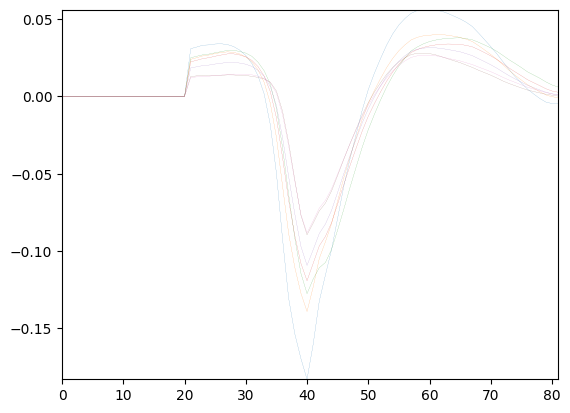

In [88]:
plt.plot(clu_df.loc[10,'main_wav_7']);

In [14]:
def collect_bouts_df(bout_df, bout_dict, spk_df, clu_list, mic_stream, pre_stream, stim_stream, tag_stream, t_pre=-2, t_post=2):
    # get t_pre, t_post in samples for wav, ap
    # tet start_end samples for each
    # collect the spikes
    # collect the streams
    bout_dict['t_pre'] = t_pre
    bout_dict['t_post'] = t_post
    
    sf_ap = bout_dict['s_f_ap_0']
    sf = bout_dict['s_f']
    
    pre_ap, post_ap = [int(x * sf_ap) for x in [t_pre, t_post]]
    pre_wav, post_wav = [int(x * sf) for x in [t_pre, t_post]]
    
    bout_df['len_sample_ap_0'] = (bout_df['len_ms'] * sf_ap * 0.001).astype(int)
    bout_df['end_sample_ap_0'] = bout_df['start_sample_ap_0'] + bout_df['len_sample_ap_0']

    bout_df['spk_arr'] = bout_df.apply(lambda x: ks.get_window_spikes(spk_df, clu_list, 
                                                                      x['start_sample_ap_0'] + pre_ap, 
                                                                      x['end_sample_ap_0'] + post_ap), 
                                       axis=1)

    bout_df['mic_arr'] = bout_df.apply(lambda x: mic_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav], 
                                       axis=1)
    bout_df['pre_arr'] = bout_df.apply(lambda x: pre_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav], 
                                       axis=1)
    
    bout_df['stim_arr'] = bout_df.apply(lambda x: stim_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav], 
                                       axis=1)
    bout_df['tag_arr'] = bout_df.apply(lambda x: tag_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav], 
                                       axis=1)
    
    # while we are at it, compute the spectrograms (ms scale)
    bout_df['sxx'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), sf))
    
    # split the spectrogram to be able to work with hdf5 save/load.
    # don't want to be saving tuples, rather arrays
    bout_df[['f_xx', 't_xx', 's_xx']] = pd.DataFrame(bout_df['sxx'].tolist(), index=bout_df.index)
    
    # while we are at it, compute the spectrograms (ms scale)
    bout_df['s_xx_stim'] = bout_df['stim_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), sf)[-1])
    bout_df['s_xx_tag'] = bout_df['tag_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), sf)[-1])
    
    # split the spectrogram to be able to work with hdf5 save/load.
    # don't want to be saving tuples, rather arrays
    bout_df[['f_xx', 't_xx', 's_xx']] = pd.DataFrame(bout_df['sxx'].tolist(), index=bout_df.index)
    
    bout_df['clu_id_arr'] = [clu_list for x in bout_df.index]
    
    return bout_df

In [15]:
### one spk_arr
# mot_idx = 0

# start_ap = bout_df.loc[mot_idx, 'start_sample_ap_0']
# end_ap = bout_df.loc[mot_idx, 'end_sample_ap_0']

# spk_arr = ks.get_window_spikes(spk_df, clu_list, start_ap - 60000 , end_ap+60000)

In [16]:
clu_list = np.unique(clu_df.loc[(clu_df['group']=='good') & (clu_df['nucleus'].isin(['ncm']) & (clu_df['n_spike']>n_spk_cutoff)), 
                                'cluster_id'])
#clu_list = []

t_pre = - 5
t_post = 5

bout_df = collect_bouts_df(bout_df, bout_dict, spk_df, clu_list, mic_stream, pre_stream, stim_stream, tag_stream,
                           t_pre=t_pre, t_post=t_post)

stim_df = collect_bouts_df(stim_df, stim_dict, spk_df, clu_list, mic_stream, pre_stream, mic2_stream, tag_stream,
                           t_pre=t_pre, t_post=t_post)

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:112: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:112: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


### Determine which bouts/stims have stim and song

In [18]:
# filter the pressure signal
b, a = signal.butter(4, 1000, 'lp', fs=bout_dict['s_f'], output='ba')
bout_df['pre_filt'] = bout_df['pre_arr'].apply(lambda x: signal.filtfilt(b, a, x))
stim_df['pre_filt'] = stim_df['pre_arr'].apply(lambda x: signal.filtfilt(b, a, x))

# convert pressure to better units
v_daq_range = 5
v_s = 3.33
p_max = 6.89
p_min = -6.89
bout_df['pre_kpa'] = ((bout_df['pre_filt']/32768*v_daq_range)/v_s - 0.1) * (p_max - p_min)/0.8 + p_min
stim_df['pre_kpa'] = ((bout_df['pre_filt']/32768*v_daq_range)/v_s - 0.1) * (p_max - p_min)/0.8 + p_min

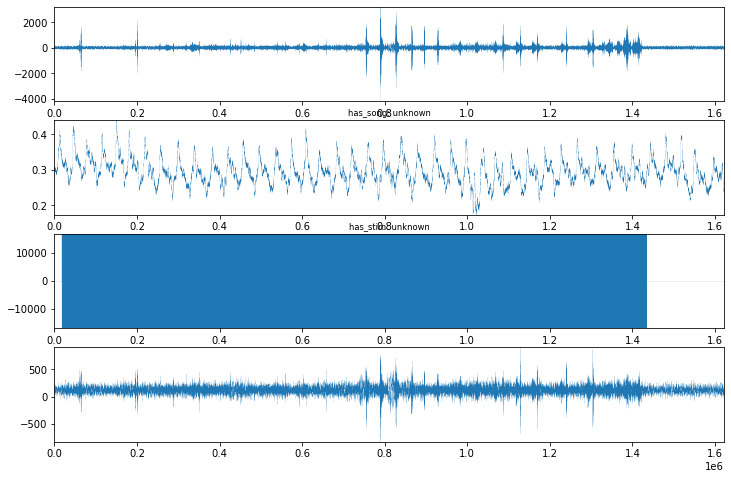

In [20]:
def plot_bout_daqs(bout_series, bout_dict):
    # get the raster, the spectrogram and the pressure
    
    t_pre = bout_dict['t_pre']
    s_f_ap = bout_dict['s_f_ap_0']
    s_f = bout_dict['s_f']
    
    mic_arr = bout_series['mic_arr']
    pre_arr = bout_series['pre_kpa']
    tag_arr = bout_series['tag_arr']
    stim_arr = bout_series['stim_arr']
    # plot
    
    fig, ax = plt.subplots(nrows=4, gridspec_kw={'height_ratios': [1, 1, 1, 1]}, figsize=(12, 8))

    f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f)

    #ax[0].plot(mic_arr.flatten())
    #ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[0].plot(mic_arr.flatten())
    ax[1].plot(pre_arr.flatten());
    try:
        has_song = (bout_series['has_song'])
    except KeyError:
        has_song = 'unknown'
    ax[1].set_title('has_song: {}'.format(has_song))
    
    # f, t, sxx = sp.ms_spectrogram(tag_arr.flatten(), s_f)
    # ax[2].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[2].plot(tag_arr.flatten())
    try:
        has_stim = (bout_series['has_stim'])
    except KeyError:
        has_stim = 'unknown'
    ax[2].set_title('has_stim: {}'.format(has_stim))
    
    f, t, sxx = sp.ms_spectrogram(stim_arr.flatten(), s_f)
    #ax[3].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[3].plot(stim_arr.flatten())
    
    #pu.plot_as_raster(spk_arr, t_0=int(-t_pre*1000), ax=ax[2])
    
plot_bout_daqs(bout_df.iloc[60], bout_dict)

#### who has stimulus
get this from the stim_tag sine wave channel

In [21]:
def has_stim(bout_df: pd.DataFrame, bout_dict: dict) -> pd.DataFrame:
    # check if the bout has stimulus in it, based on the tag channel part of it.
    s_pre = - int(bout_dict['s_f_nidq'] * bout_dict['t_pre'])
    s_post = int(bout_dict['s_f_nidq'] * bout_dict['t_post'])
    s_f = bout_dict['s_f_nidq']
    thresh = 1e5
    
    bout_df['stim_ttl'], bout_df['stim_ttl_t'] = zip(*bout_df['tag_arr'].apply(lambda x: su.sine_to_ttl(x.flatten(),
                                                                                                         s_f,
                                                                                                         fixed_threshold=thresh)))                                                   
    bout_df['stim_ttl_eval'], bout_df['stim_ttl_t_eval'] = zip(*bout_df['tag_arr'].apply(lambda x: su.sine_to_ttl(x[:-s_post],
                                                                                                         s_f,
                                                                                                         fixed_threshold=thresh)))
    bout_df['has_stim'] = bout_df['stim_ttl'].apply(lambda x: np.any(x>0))
    return bout_df

bout_df = has_stim(bout_df, bout_dict)
stim_df = has_stim(stim_df, stim_dict)

#### who has song
get this from the pressure segmentation of bouts

(array([ 311612,  428344,  506070,  563616,  623138,  723323,  744389,
         969303, 1029659, 1038159, 1109879, 1175887, 1257681, 1303499,
        1351220, 1375502, 1401502, 1427769, 1458812, 1495475, 1534537,
        1566403, 1600072, 1633152, 1647425, 1671521, 1691260, 1715136,
        1732159, 1755811, 1787783, 1824108, 1865063, 1889714, 1923390,
        1950863, 1985032, 2005226, 2025140, 2044921, 2068384]),
 array([ 321083,  435512,  525840,  585883,  648345,  729985,  805393,
        1018612, 1034807, 1091484, 1162830, 1246408, 1299604, 1349875,
        1373749, 1399227, 1425733, 1451771, 1488579, 1527589, 1564342,
        1597910, 1631639, 1645899, 1670178, 1690197, 1713240, 1730769,
        1754458, 1784509, 1821399, 1862167, 1886302, 1920492, 1947116,
        1981939, 2003109, 2023025, 2042755, 2065153, 2085718]))

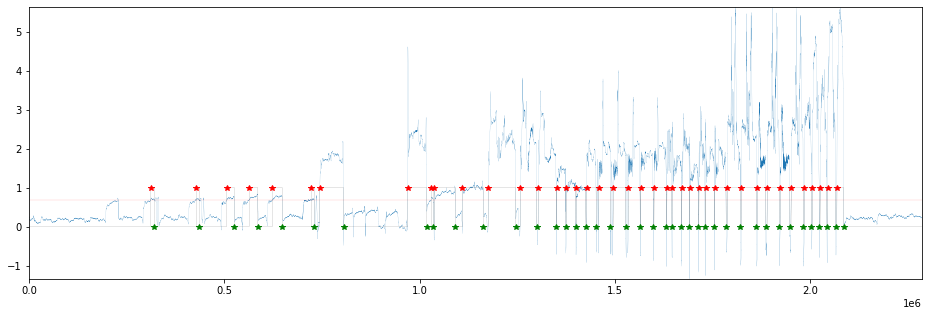

In [22]:
reload(pru)
pru.segment_series(bout_df.iloc[6], bout_dict, p_max/10, plot=True)

In [23]:
reload(pru)
# segment all bouts: failed segmentation means no syllables found in pressure: no song.
bout_df[['s_on', 's_off']] = bout_df.apply(lambda s: pru.segment_series(s, bout_dict, p_max/10), 
                                           axis=1, 
                                           result_type='expand')

stim_df[['s_on', 's_off']] = stim_df.apply(lambda s: pru.segment_series(s, stim_dict, p_max/10), 
                                           axis=1, 
                                           result_type='expand')

pre_s = bout_dict['t_pre'] * bout_dict['s_f']
bout_df['has_song'] = bout_df['s_on'].apply(lambda x: np.any(x>pre_s))

stim_df['has_song'] = stim_df['s_on'].apply(lambda x: np.any(x>0))

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/pressure.py:97: UserWarning: Failed segmenting bout 494591760
  warnings.warn('Failed segmenting bout {}'.format(ds['start_sample']))
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/pressure.py:97: UserWarning: Failed segmenting bout 807264160
  warnings.warn('Failed segmenting bout {}'.format(ds['start_sample']))
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/pressure.py:97: UserWarning: Failed segmenting bout 602892960
  warnings.warn('Failed segmenting bout {}'.format(ds['start_sample']))
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/pressure.py:97: UserWarning: Failed segmenting bout 659811080
  warnings.warn('Failed segmenting bout {}'.format(ds['start_sample']))
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/pressure.py:97: UserWarning: Failed segmenting bout 641665480
  warnings.warn('Failed segmenting bout {}'.format(ds['start_sample']))
/mnt/cube/earneodo/repos/cecie

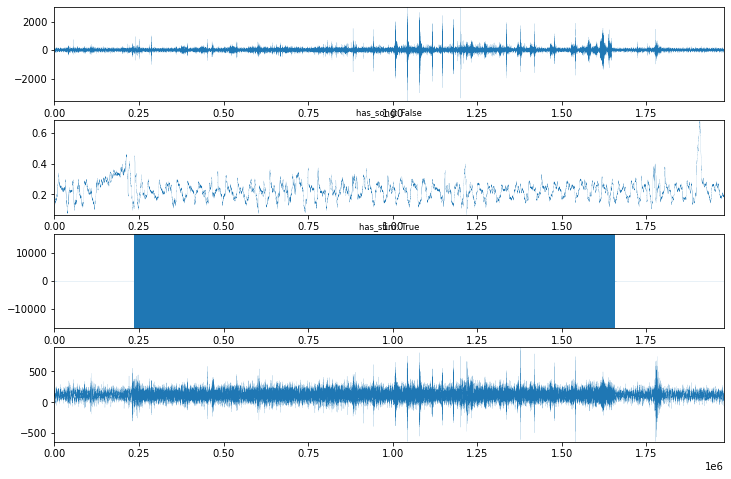

In [24]:
plot_bout_daqs(bout_df.iloc[30], bout_dict)

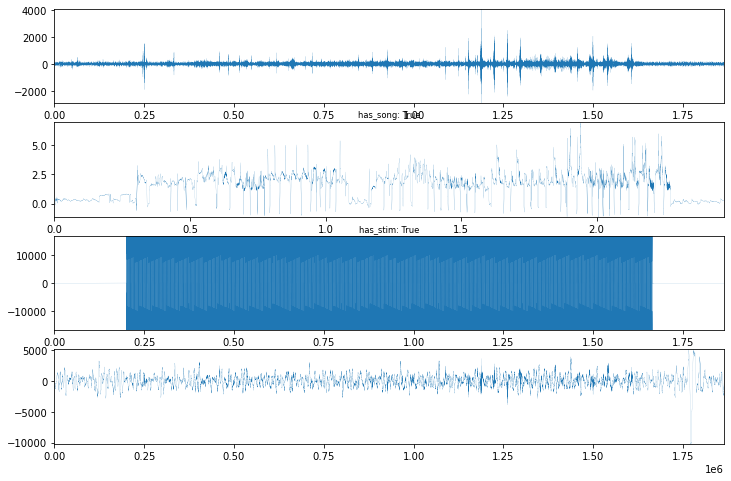

In [25]:
plot_bout_daqs(stim_df.iloc[2], stim_dict)

#### filter out
- bout_df with no song have to go
- stim_df with no stim have to gom

In [26]:
bout_df.drop(bout_df.loc[bout_df['has_song'] == False].index, inplace=True)
stim_df.drop(stim_df.loc[stim_df['has_stim'] == False].index, inplace=True)

In [27]:
bout_df = pd.concat([bout_df, stim_df])
bout_df.reset_index(inplace=True)

In [ ]:
#### fix compatibilities between concatenated sets
bout_df['syl_in'] = bout_df['syl_in'].apply(lambda x: np.ones([1,2])*np.nan if np.all(np.isnan(x))  else x) # h5py (for saving) doesn't like datasets with just one nan.

### look where there is stimulus, song, and overlap
- only song (nothing in the stim_tag chan)
two stim cases:
    - only stim (high similarity bwtween stim and mic)
    - mixed (differences between stim and mic)

In [28]:
ms_sample_ap = int(1*0.001*bout_dict['s_f_ap_0'])
bout_df['spk_ms_arr'] = bout_df['spk_arr'].apply(lambda z: np.nan_to_num(pu.coarse(z, ms_sample_ap)))

##### sanity check, plot one of the bout-rasters

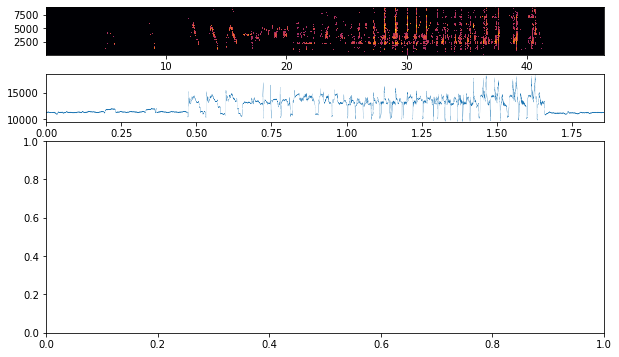

In [30]:
def plot_bout(bout_series, bout_dict):
    # get the raster, the spectrogram and the pressure
    
    t_pre = bout_dict['t_pre']
    s_f_ap = bout_dict['s_f_ap_0']
    s_f = bout_dict['s_f']
    
    mic_arr = bout_series['mic_arr']
    pre_arr = bout_series['pre_arr']
    spk_arr = bout_series['spk_ms_arr']
    # plot
    
    fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 4]}, figsize=(10, 6))

    f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f)

    #ax[0].plot(mic_arr.flatten())
    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[1].plot(pre_arr.flatten());
    #pu.plot_as_raster(spk_arr, t_0=int(-t_pre*1000), ax=ax[2])
    
plot_bout(bout_df.iloc[33], bout_dict)

##### get extra observables:
- spk_ms_arr
- spectrograms
- pca of spectrogram
- 'fake' pressure (placeholder with log(env)
- filtered pressure

In [46]:
ms_sample_ap = int(1*0.001*bout_dict['s_f_ap_0'])

bout_df['spk_ms_arr'] = bout_df['spk_arr'].apply(lambda z: np.nan_to_num(pu.coarse(z, ms_sample_ap)))

bout_df['sxx'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), bout_dict['s_f']))

In [47]:
from ceciestunepipe.util.dimension import gpfa as gpf

In [48]:
# get the spectrogram into ['sxx_pc']
bout_df = gpf.spec_pca_for_bout(bout_df, bout_dict)

In [ ]:
%matplotlib inline

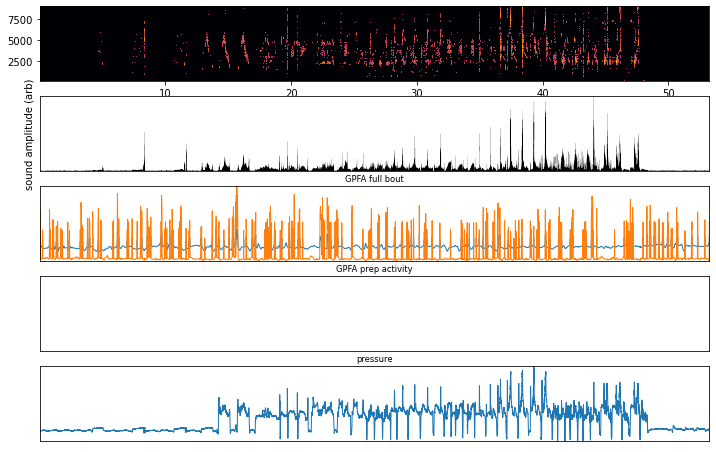

In [50]:
### se them together all for a bout now
def plot_bout_projections(bout_series):
    sxx_pc = bout_series['sxx_pc']
    gpf = bout_series['spk_gpf']
    #gpf_prep = bout_df['spk_gpf-prep']
    pre_arr = bout_series['pre_filt']
    mic_arr = bout_series['mic_arr']
    
    f, t, sxx = bout_series['sxx']
    
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 8));

    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    
    ax[1].plot((np.abs(mic_arr)), 'k');
    ax[1].set_ylabel('sound amplitude (arb)')

    ax[2].set_title('GPFA full bout')
    #ax[2].plot(sxx_pc, lw=1);
    ax[2].plot(gpf[:2].T, lw=1);

    ax[3].set_title('GPFA prep activity');
    #ax[3].plot(bout_series['spk_gpf-hyb'][:2].T, lw=1);

    ax[4].set_title('pressure');
    ax[4].plot(pre_arr, lw=1);
    
    for ax_i in ax[1:]:
        ax_i.set_xticks([])
        ax_i.set_yticks([])
    
    return ax


plot_bout_projections(bout_df.iloc[12]);

In [88]:
### save these bouts as an hdf5 file
bout_df_name = 'boutstim_df_gpfa-{}.h5'.format(gpfa_bin_ms)
bout_df_path = os.path.join(exp_struct['folders']['processed'], bout_df_name)
fu.makedirs(exp_struct['folders']['processed'])

In [92]:
# in the h5 file, each bout is a group, scalars go as attr, arrays go as dsets

attr_keys = ['start_ms', 'end_ms', 'len_ms', 
             'start_sample', 'end_sample',
             'start_ms_ap_0', 'start_sample_ap_0',
             'start_sample_naive', 'len_sample_ap_0', 'end_sample_ap_0',
             'bout_check', 'confusing', 'file', 'is_call']

extra_attr_keys = ['has_stim', 'has_song', 'stim_name', 'tag_freq_int', 'tag_freq',
                   'start_sample_nidq']


dset_keys = ['mic_arr', 'pre_arr', 'pre_filt', 'syl_in',
             'f_xx', 't_xx', 's_xx', 'sxx_pc', 
             'spk_gpf', 'spk_ms_arr', 'spk_arr'] #

# extra dset_keys that will not necessarily always be there
extra_dset_keys = ['tag_arr', 'clu_id_arr', 'pre_kpa', 
                  'stim_ttl', 'stim_ttl_t', 'stim_ttl_eval', 'stim_ttl_t_eval',
                  's_on', 's_off',
                  ]

dict_keys = ['s_f', 's_f_nidq', 's_f_ap_0', 't_pre', 't_post', 'gpfa_bin_ms', 'gpfa_xdim']

logger.info('Saving the gpfa, pca results onto an hdf5 file {}'.format(bout_df_path))
h5u.bouts_to_h5(bout_df, bout_dict, dset_keys + extra_dset_keys, attr_keys, dict_keys, bout_df_path)
logger.info('done')

2023-05-08 17:26:46,933 root         INFO     Saving the gpfa, pca results onto an hdf5 file /mnt/sphere/speech_bci/processed_data/s_b1560_22/2023-04-21/sglx/1150_stim_g0/boutstim_df_gpfa-15.h5
2023-05-08 17:33:29,994 root         INFO     done
